# Fitting a model to data with both x and y errors with `BILBY`

Usually when we fit a model to data with a Gaussian Likelihood we assume that we know x values exactly. This is almost never the case. Here we show how to fit a model with errors in both x and y.

In [2]:
import bilby
import inspect
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### First we create the data and plot it

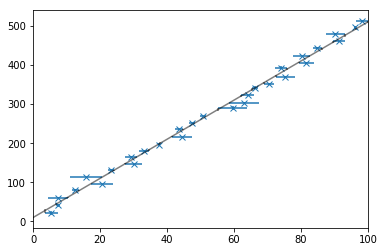

In [4]:
#define our model, a line
def model(x, m, c, **kwargs):
    y = m*x + c
    return y

#make a function to create and plot our data
def make_data(points, m , c, xerr, yerr, seed):
    np.random.seed(int(seed))
    xtrue = np.linspace(0,100,points)
    ytrue = model(x = xtrue, m = m, c = c)

    xerr = xerr * np.random.randn(points)
    yerr = yerr * np.random.randn(points)
    xobs = xtrue + xerr
    yobs = ytrue + yerr
    
    plt.errorbar(xobs, yobs, xerr = xerr, yerr = yerr, fmt = 'x')
    plt.errorbar(xtrue, ytrue, yerr = yerr, color = 'black', alpha = 0.5)
    plt.xlim(0,100)
    plt.show()
    
    data = {'xtrue': xtrue, 'ytrue':ytrue, 'xobs':xobs, 'yobs':yobs, 'xerr':xerr, 'yerr':yerr}
    
    return data

data = make_data(points = 30, m = 5, c = 10, xerr = 2, yerr = 2, seed = 123)

### Now lets set up the prior and bilby output directory

In [5]:
#setting up bilby priors
priors = dict(m=bilby.core.prior.Uniform(0, 30, 'm'),
              c=bilby.core.prior.Uniform(0, 30, 'c'))

outdir = 'outdir'
livepoints = 100
walks = 10

### Our first step is to recover the straight line using a simple Gaussian Likelihood that only takes into account the y errors. Under the assumption we know x exactly. In this case, we pass in xtrue for x

In [6]:
OneDGaussian_knownx = bilby.core.likelihood.GaussianLikelihood(x = data['xtrue'], y = data['yobs'], func = model, sigma = data['yerr'])
result_1D_xtrue = bilby.run_sampler(
    likelihood=OneDGaussian_knownx, priors=priors, sampler='dynesty', npoints=livepoints,
    walks=walks, outdir=outdir, label='xtrue_1D_Gaussian')

14:36 bilby INFO    : Search parameters:
14:36 bilby INFO    :   m = Uniform(minimum=0, maximum=30, name='m', latex_label='m', unit=None)
14:36 bilby INFO    :   c = Uniform(minimum=0, maximum=30, name='c', latex_label='c', unit=None)
14:36 bilby INFO    : Single likelihood evaluation took 5.400e-05 s
14:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 10, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c14ef1128>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print

14:36 bilby INFO    : Plotting 1000 draws
14:36 bilby INFO    : Plotting maximum likelihood


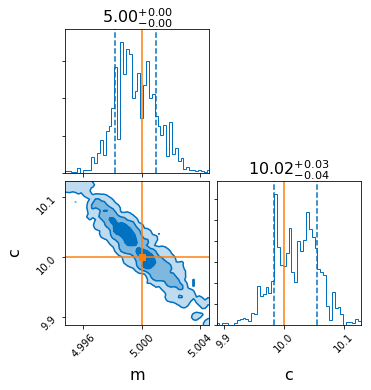

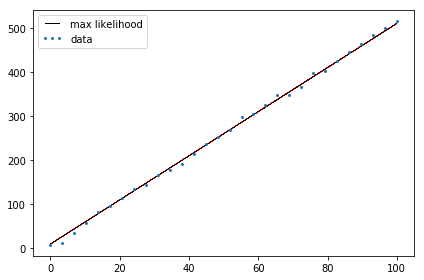

In [7]:
result_1D_xtrue.plot_corner(truth=dict(m=5, c = 10), titles = True)
result_1D_xtrue.plot_with_data(model = model, x = data['xtrue'], y = data['yobs'], ndraws=1000, npoints=100)
plt.show()

### As expected this is easy to recover and the sampler does a good job. However this was made too easy - by passing in the 'true' values of x. Lets see what happens when we pass in the observed values of x

In [8]:
OneDGaussian_unknownx = bilby.core.likelihood.GaussianLikelihood(x = data['xobs'], y = data['yobs'], 
                                                                 func = model, sigma = data['yerr'])
result_1D_xobs = bilby.run_sampler(
    likelihood=OneDGaussian_unknownx, priors=priors, sampler='dynesty', npoints=livepoints,
    walks=walks, outdir=outdir, label='xobs_1D_Gaussian')

14:36 bilby INFO    : Search parameters:
14:36 bilby INFO    :   m = Uniform(minimum=0, maximum=30, name='m', latex_label='m', unit=None)
14:36 bilby INFO    :   c = Uniform(minimum=0, maximum=30, name='c', latex_label='c', unit=None)
14:36 bilby INFO    : Single likelihood evaluation took 6.800e-05 s
14:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 10, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c1d2d78d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print

14:37 bilby INFO    : Sampling time: 0:00:24.542608
14:37 bilby INFO    : Results saved to outdir/
14:37 bilby INFO    : Summary of results:
nsamples: 3108
log_noise_evidence:    nan
log_evidence: -3119016.700 +/-  0.511
log_bayes_factor:    nan +/-  0.511



14:37 bilby INFO    : Plotting 1000 draws
14:37 bilby INFO    : Plotting maximum likelihood


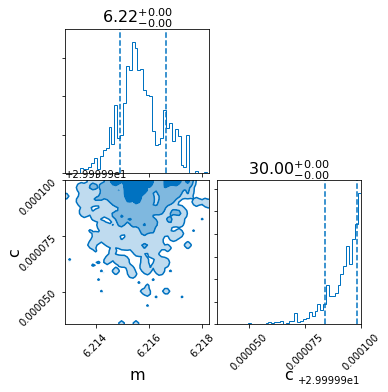

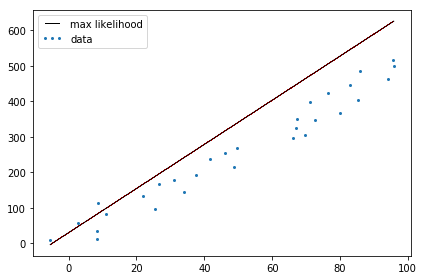

In [9]:
result_1D_xobs.plot_corner(truth=dict(m=5, c = 10), titles = True)
result_1D_xobs.plot_with_data(model = model, x = data['xobs'], y = data['yobs'], ndraws=1000, npoints=100)
plt.show()

### As expected, this is significantly worse. Let us now define a new likelihood which takes into account x errors but you also pass in xtrue

In [10]:
class TwoDGaussianLikelihood_knownxtrue(bilby.Likelihood):
    def __init__(self, xtrue, xobs, yobs, xerr, yerr, function):
        """

        Parameters
        ----------
        xtrue: array_like 
            The true injected x values
        xobs, yobs: array_like
            The data to analyse
        xerr, yerr: array_like
            The standard deviation of the noise
        function:
            The python function to fit to the data
        """
        self.xobs = xobs
        self.xtrue = xtrue
        self.yobs = yobs
        self.yerr = yerr
        self.xerr = xerr
        self.function = function
        parameters = inspect.getargspec(function).args
        parameters.pop(0)
        self.parameters = dict.fromkeys(parameters)

    def log_likelihood(self):
        resy = self.yobs - self.function(self.xtrue, **self.parameters)
        resx = self.xobs - self.xtrue
        return -0.5 * (np.sum(((resy) / self.yerr) ** 2) + np.sum(((resx) / self.xerr) ** 2))

In [11]:
TwoDGaussian_knownx = TwoDGaussianLikelihood_knownxtrue(xtrue = data['xtrue'], xobs = data['xobs'], 
                                                        yobs = data['yobs'], xerr=data['xerr'], 
                                                        yerr = data['yerr'], function=model)
result_2D_knownx = bilby.run_sampler(
    likelihood=TwoDGaussian_knownx, priors=priors, sampler='dynesty', npoints=livepoints,
    walks=walks, outdir=outdir, label='knownx_2D_Gaussian')

/Users/nsarin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
14:37 bilby INFO    : Search parameters:
14:37 bilby INFO    :   m = Uniform(minimum=0, maximum=30, name='m', latex_label='m', unit=None)
14:37 bilby INFO    :   c = Uniform(minimum=0, maximum=30, name='c', latex_label='c', unit=None)
14:37 bilby INFO    : Single likelihood evaluation took 6.500e-05 s
14:37 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 10, 'update_interval': 60, 'print_func': <b

14:37 bilby INFO    : Plotting 1000 draws
14:37 bilby INFO    : Plotting maximum likelihood


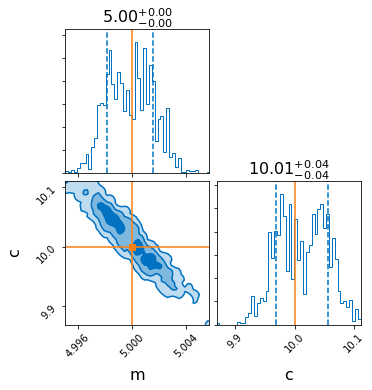

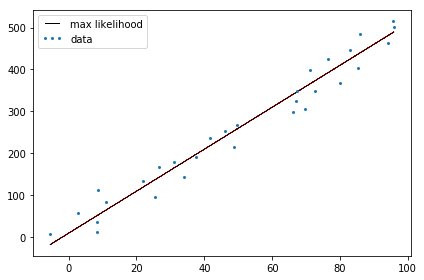

In [12]:
result_2D_knownx.plot_corner(truth=dict(m=5, c = 10), titles = True)
result_2D_knownx.plot_with_data(model = model, x = data['xobs'], y = data['yobs'], ndraws=1000, npoints=100)
plt.show()

### This works well, however it still is not realistic as one still needs to 'know' the true x values. Getting around this requires marginalisation of the true x values or sampling over them.  See discussion in section 7 of https://arxiv.org/pdf/1008.4686.pdf

In [13]:
class TwoDGaussianLikelihood_unknownx(bilby.Likelihood):
    def __init__(self, xobs, yobs, xerr, yerr, function):
        """

        Parameters
        ----------
        xobs, yobs: array_like
            The data to analyse
        xerr, yerr: array_like
            The standard deviation of the noise
        function:
            The python function to fit to the data
        """
        self.xobs = xobs
        self.yobs = yobs
        self.yerr = yerr
        self.xerr = xerr
        self.function = function
        parameters = inspect.getargspec(function).args
        parameters.pop(0)
        self.parameters = dict.fromkeys(parameters)

    def log_likelihood(self):
        m = self.parameters['m']
        v = np.array([-m, 1.0])
        
        Sigma2 = (self.xerr*m)**2 + self.yerr**2
        model_y = self.function(self.xobs, **self.parameters)
        Delta = self.yobs - model_y

        ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
                
        return ll

In [14]:
TwoDGaussian_unknownx = TwoDGaussianLikelihood_unknownx(xobs = data['xobs'], yobs = data['yobs'], 
                                                        xerr= data['xerr'], yerr = data['yerr'],
                                                        function=model)
result_2D_unknownx = bilby.run_sampler(
    likelihood=TwoDGaussian_unknownx, priors=priors, sampler='dynesty', npoints=livepoints,
    walks=walks, outdir=outdir, label='unknownx_2D_Gaussian')

/Users/nsarin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
14:37 bilby INFO    : Search parameters:
14:37 bilby INFO    :   m = Uniform(minimum=0, maximum=30, name='m', latex_label='m', unit=None)
14:37 bilby INFO    :   c = Uniform(minimum=0, maximum=30, name='c', latex_label='c', unit=None)
14:37 bilby INFO    : Single likelihood evaluation took 4.600e-05 s
14:37 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 10, 'update_interval': 60, 'print_func': <b

14:37 bilby INFO    : Plotting 1000 draws
14:37 bilby INFO    : Plotting maximum likelihood


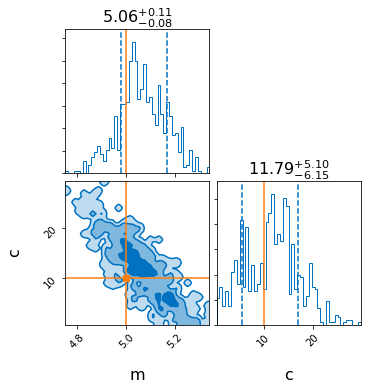

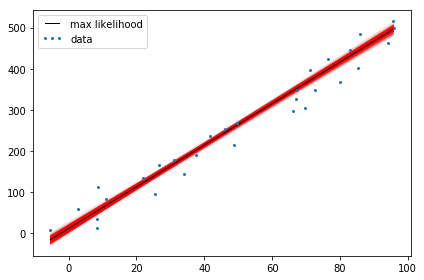

In [15]:
result_2D_unknownx.plot_corner(truth=dict(m=5, c = 10), titles = True)
result_2D_unknownx.plot_with_data(model = model, x = data['xobs'], y = data['yobs'], ndraws=1000, npoints=100)
plt.show()

### Another approach to getting around 'knowing true values of x' is to sample over them. This is problematic for several samplers as each x data point adds a dimension.

### You can use hamiltonian monte carlo and/or PyStan to get around this problem and fit more complicated stuff